In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import re  # Import the re module for regular expressions
import random  # Import the random module

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK resources
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt_tab')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [4]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [5]:
df_scraped = pd.read_csv('scraped_pubmed_abstract_100.csv')

df_scraped.shape

(1000, 2)

In [6]:
df_scraped.head()

,Label,Abstract
0,clinical depression,Although anxiety and depression have been cons...
1,clinical depression,Major depression is one of the most prevalent ...
2,clinical depression,ObjectiveAdolescence is a formative and turbul...
3,clinical depression,2001 to 2020 was CI Point prevalence for major...
4,clinical depression,Major depressive disorder MDD is considered a ...


# Text Preprocessing and Vectorizing


In [7]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text.lower())
    # Remove stop words and non-alphanumeric tokens
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]

    return " ".join(filtered_words)

# Example of transforming text using TF-IDF
def transform_to_tfidf(partitions):
    vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Bigrams (1,2) and top 1000 features
    tfidf_matrix = vectorizer.fit_transform(partitions)
    return tfidf_matrix, vectorizer

In [8]:
df_scraped['Processed_Text'] = df_scraped['Abstract'].apply(preprocess_text)
print(df_scraped[['Label', 'Processed_Text']].head())

                 Label                                     Processed_Text
0  clinical depression  although anxiety depression considered two dis...
1  clinical depression  major depression one prevalent debilitating pe...
2  clinical depression  objectiveadolescence formative turbulent phase...
3  clinical depression  ci point prevalence major depressive disorder ...
4  clinical depression  major depressive disorder mdd considered serio...


In [9]:
# Store the original (non-preprocessed) text before vectorization
labels = df_scraped['Label']
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_scraped['Abstract'], labels, test_size=0.2, random_state=42
)


In [10]:
# Transform the preprocessed text into TF-IDF features
tfidf_matrix, vectorizer = transform_to_tfidf(df_scraped['Processed_Text'])

#print(vectorizer.get_feature_names_out())

# Model training and Evaluation

## Model Training

In [11]:

# Define models
models = [
    SVC(),  # Support Vector Machine
    RandomForestClassifier(random_state=42),  # Random Forest Classifier
    MultinomialNB(),  # Naïve Bayes
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),  # XGBoost
    KNeighborsClassifier(),  # k-Nearest Neighbors
    SGDClassifier(random_state=42)  # Stochastic Gradient Descent
]

# Define corresponding parameter grids
parameters = [
    # SVM
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    # Random Forest
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    # Naïve Bayes
    {
        'alpha': [0.1, 1.0, 10.0]
    },
    # XGBoost
    {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    },
    {#KNN
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    # SGD
    {
        'loss': ['hinge', 'log_loss', 'modified_huber'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [1000, 2000]
    }
]

In [12]:
labels = df_scraped['Label']
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

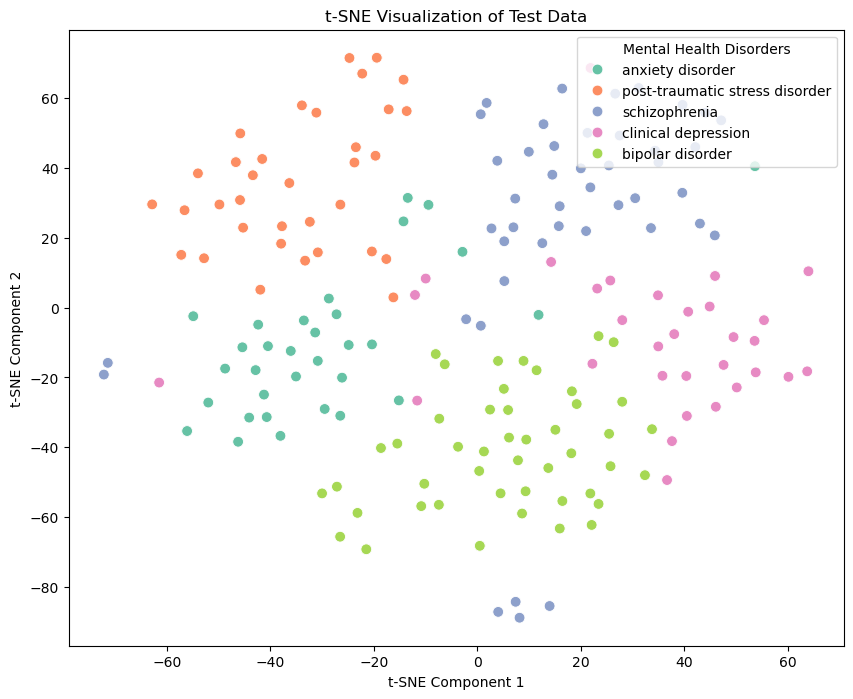

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

tsne = TSNE(n_components=2, random_state=42)  # Set random_state for reproducibility
X_test_tsne = tsne.fit_transform(X_test.toarray())  # Transform to 2D

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test, palette='Set2', legend='full', s=60)
plt.title("t-SNE Visualization of Test Data")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Mental Health Disorders', loc='upper right')
plt.show()


In [14]:
def perform_grid_search(model, params, X_train, y_train):
    grid_search = GridSearchCV(
        model,
        param_grid=params,
        cv=10,  # 10-fold cross-validation
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    return grid_search.best_estimator_

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check the mapping for reference
print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

Label Mapping:
0: anxiety disorder
1: bipolar disorder
2: clinical depression
3: post-traumatic stress disorder
4: schizophrenia


In [16]:
grid_search_best = []

# Iterate through models and parameters
for model, params in zip(models, parameters):
    print(f"Running GridSearch for {model.__class__.__name__}...")

    # Perform grid search
    grid_search = GridSearchCV(
        model,
        param_grid=params,
        cv=10,  # 10-fold cross-validation
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train_encoded)

    # Append the best model
    grid_search_best.append((model.__class__.__name__, grid_search.best_estimator_))

    # Output results
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model.__class__.__name__}: {grid_search.best_score_}\n")


Running GridSearch for SVC...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for SVC: 0.9825000000000002

Running GridSearch for RandomForestClassifier...
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score for RandomForestClassifier: 0.9812500000000002

Running GridSearch for MultinomialNB...
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters for MultinomialNB: {'alpha': 10.0}
Best cross-validation score for MultinomialNB: 0.975

Running GridSearch for XGBClassifier...
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation score for XGBClassifier: 0.9787500000000001

Running G

## Evaluate Models and Interpret Results

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
performance_data = []

for model_name, best_model in grid_search_best:
    print(f"Evaluating {model_name} on the test set...\n")

    y_pred_encoded = best_model.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred_encoded)
    y_test_decoded = label_encoder.inverse_transform(y_test_encoded)

    # Accuracy
    acc = accuracy_score(y_test_decoded, y_pred_decoded)

    # Macro F1-score
    macro_f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro')

    print(f"Accuracy Score for {model_name}: {acc:.4f}")
    print(f"Macro F1 Score for {model_name}: {macro_f1:.4f}")

    performance_data.append({'Model': model_name, 'Accuracy': acc, 'Macro F1-Score': macro_f1})

    # Classification Report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test_decoded, y_pred_decoded))    

# Convert performance data into a DataFrame
performance_df = pd.DataFrame(performance_data)
print("\nPerformance Summary:\n", performance_df)


Evaluating SVC on the test set...

Accuracy Score for SVC: 0.9950
Macro F1 Score for SVC: 0.9943
Classification Report for SVC:

                                precision    recall  f1-score   support

              anxiety disorder       0.97      1.00      0.99        37
              bipolar disorder       1.00      1.00      1.00        48
           clinical depression       1.00      0.97      0.98        33
post-traumatic stress disorder       1.00      1.00      1.00        38
                 schizophrenia       1.00      1.00      1.00        44

                      accuracy                           0.99       200
                     macro avg       0.99      0.99      0.99       200
                  weighted avg       1.00      0.99      0.99       200

Evaluating RandomForestClassifier on the test set...

Accuracy Score for RandomForestClassifier: 0.9950
Macro F1 Score for RandomForestClassifier: 0.9943
Classification Report for RandomForestClassifier:

               

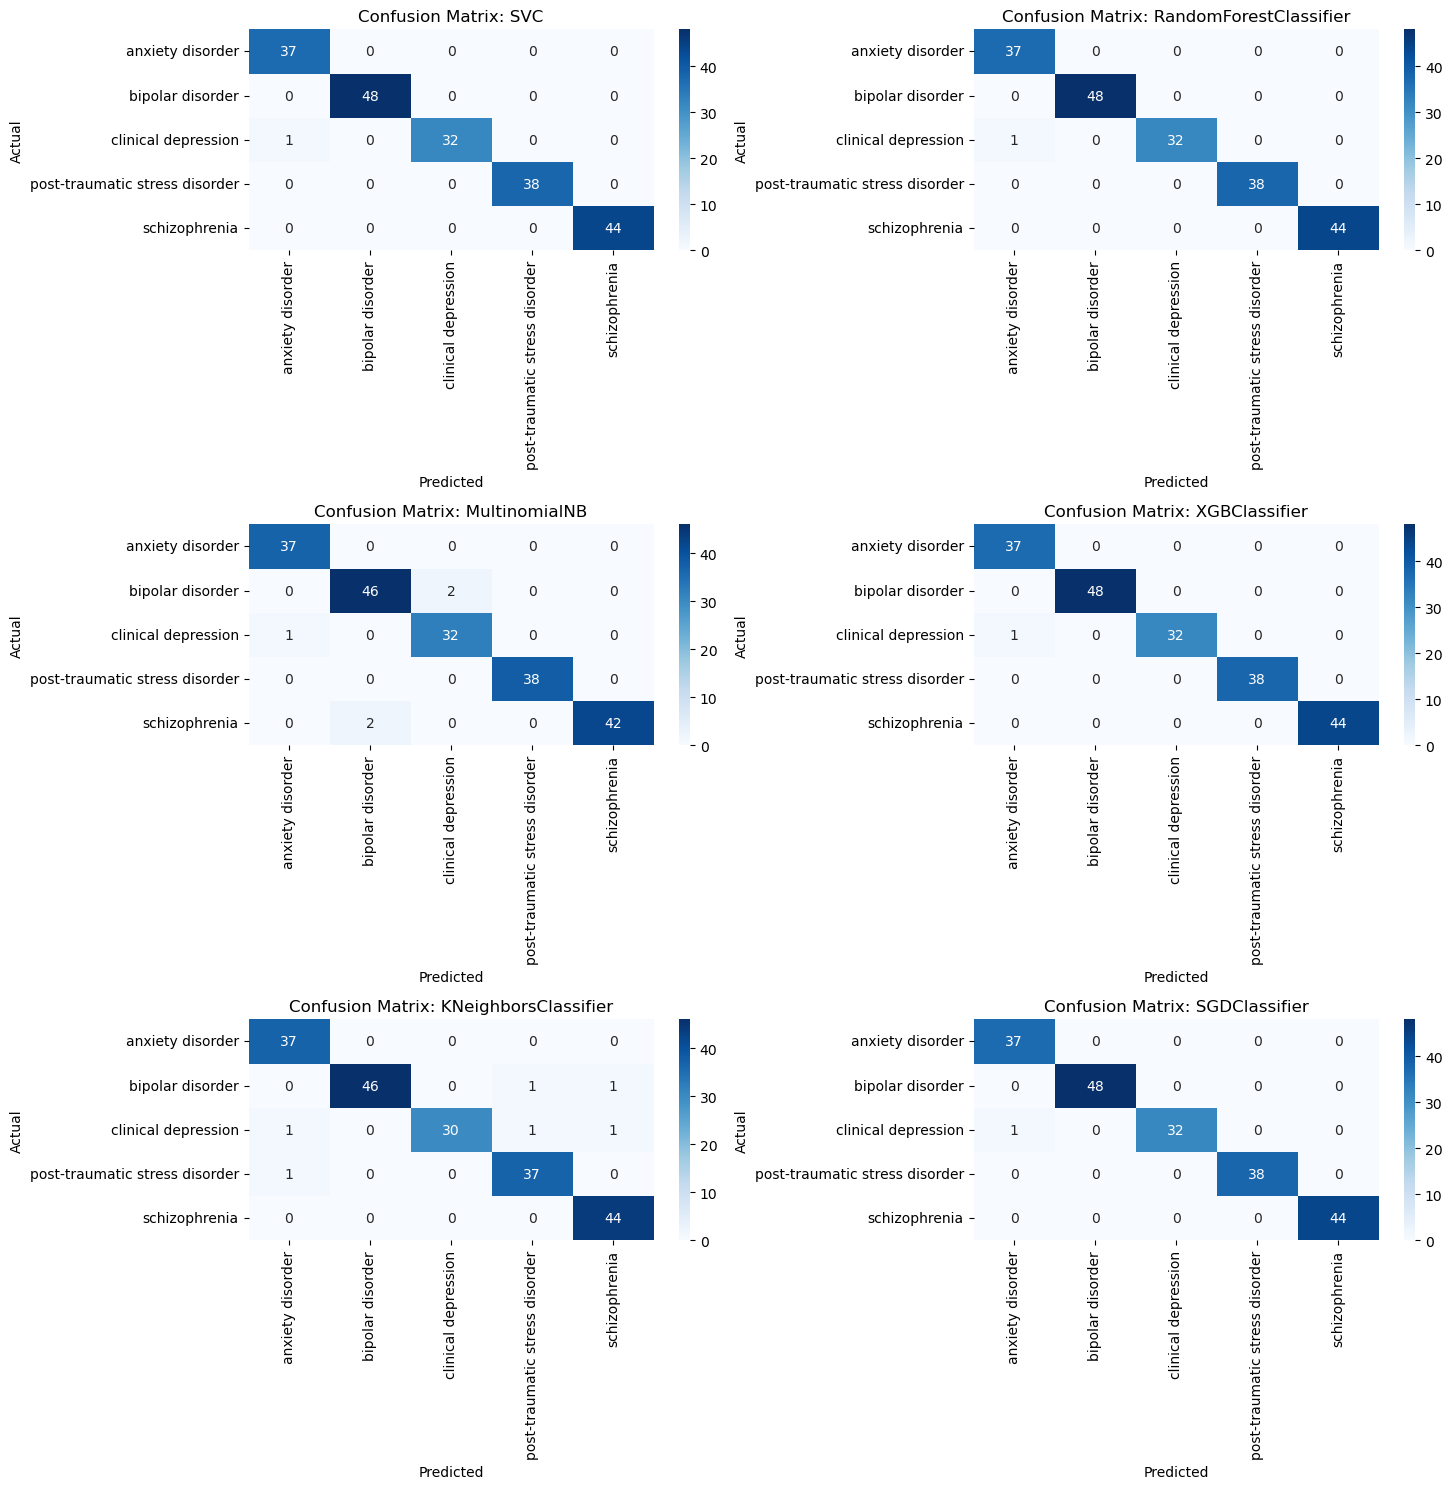

In [19]:
# Plot all confusion matrices in a 3-row, 2-column layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()  # Flatten for easy indexing

for idx, (model_name, best_model) in enumerate(grid_search_best):
    if idx >= 6:  # Limit to 6 models for visualization
        break

    y_pred_encoded = best_model.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred_encoded)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_decoded, y_pred_decoded)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix: {model_name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [20]:
# Analyzing misclassified samples separately
misclassified_samples = {}

for model_name, best_model in grid_search_best:
    y_pred_encoded = best_model.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred_encoded)
    
    # Create a DataFrame of misclassified samples
    errors = pd.DataFrame({
        'Text': X_test_text,  
        'True Label': y_test_decoded,
        'Predicted Label': y_pred_decoded
    })
    errors = errors[errors['True Label'] != errors['Predicted Label']]
    
    misclassified_samples[model_name] = errors  # Store for future use
    print(f"Misclassified Samples for {model_name}:\n", errors.head())


Misclassified Samples for SVC:
                                                  Text           True Label  \
67  An informationprocessing paradigm was used to ...  clinical depression   

     Predicted Label  
67  anxiety disorder  
Misclassified Samples for RandomForestClassifier:
                                                  Text           True Label  \
67  An informationprocessing paradigm was used to ...  clinical depression   

     Predicted Label  
67  anxiety disorder  
Misclassified Samples for MultinomialNB:
                                                   Text           True Label  \
261  For the treatment of acute BPII depression two...     bipolar disorder   
866  relationship to other conditions particularly ...        schizophrenia   
67   An informationprocessing paradigm was used to ...  clinical depression   
822  relationship to other conditions particularly ...        schizophrenia   
361  For the treatment of acute BPII depression two...     bipolar disorde

In [21]:
X_train.shape[0]-1

799

Evaluating SVC for Bias-Variance Analysis...


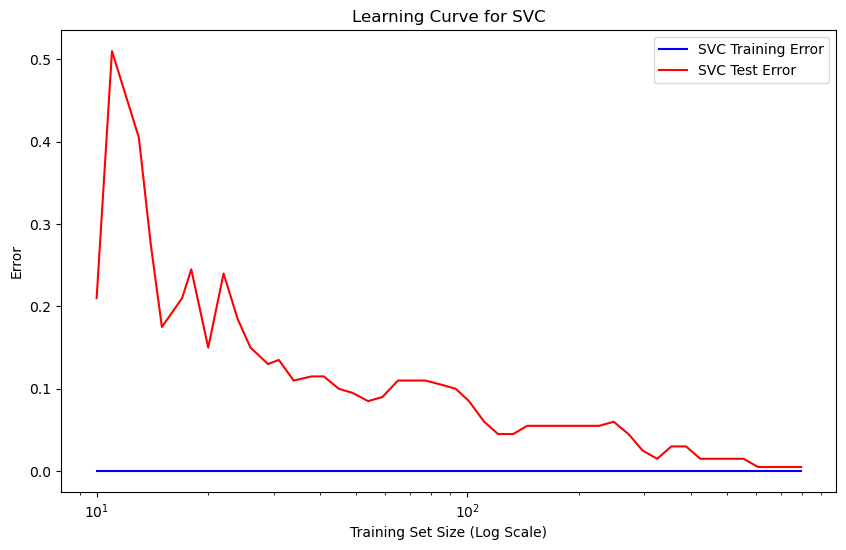

Evaluating RandomForestClassifier for Bias-Variance Analysis...


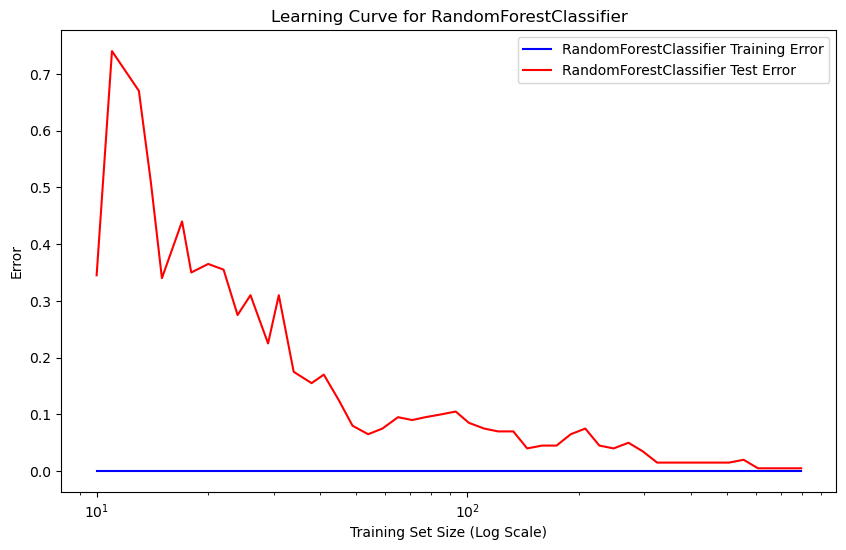

Evaluating MultinomialNB for Bias-Variance Analysis...


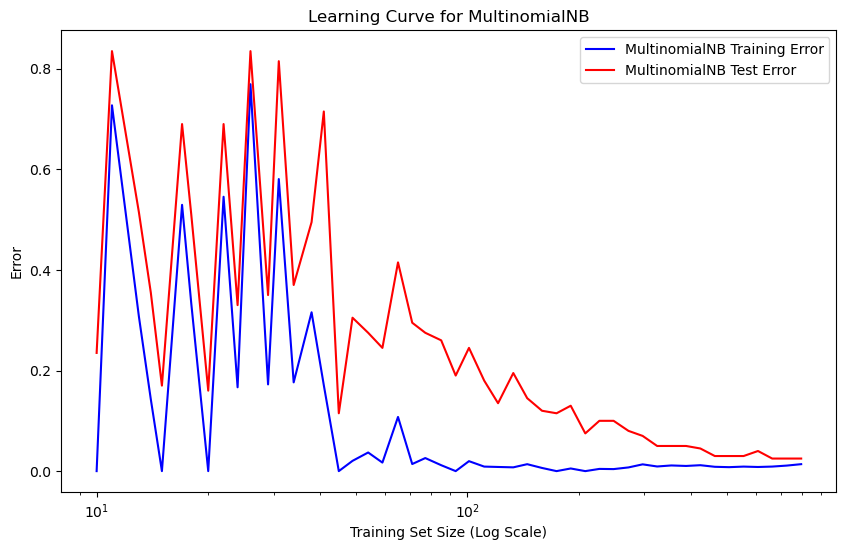

Evaluating XGBClassifier for Bias-Variance Analysis...


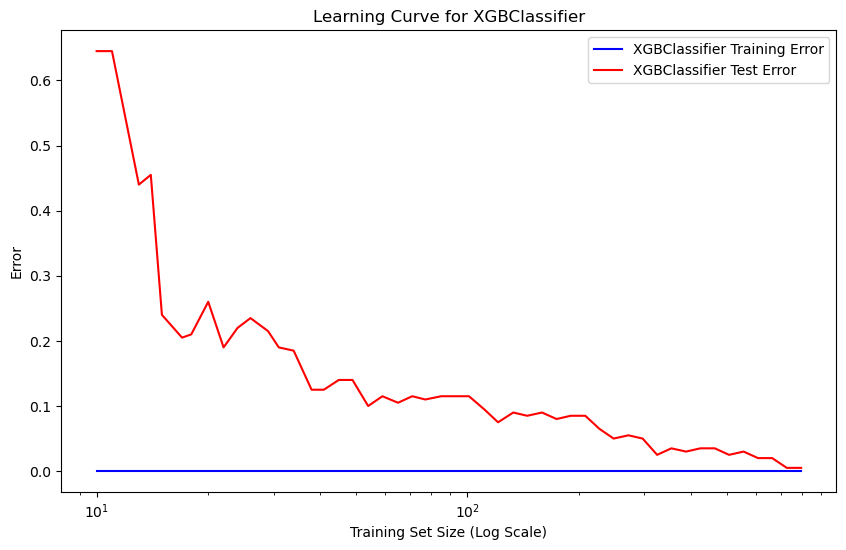

Evaluating KNeighborsClassifier for Bias-Variance Analysis...


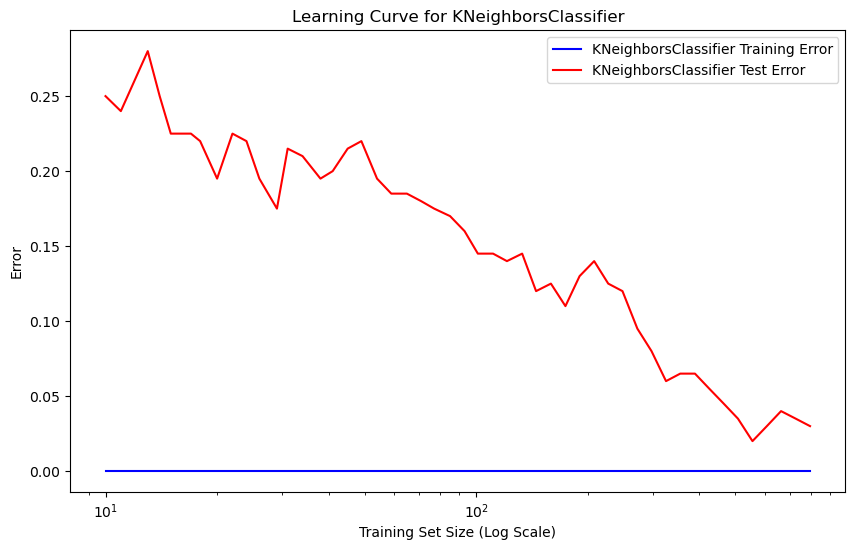

Evaluating SGDClassifier for Bias-Variance Analysis...


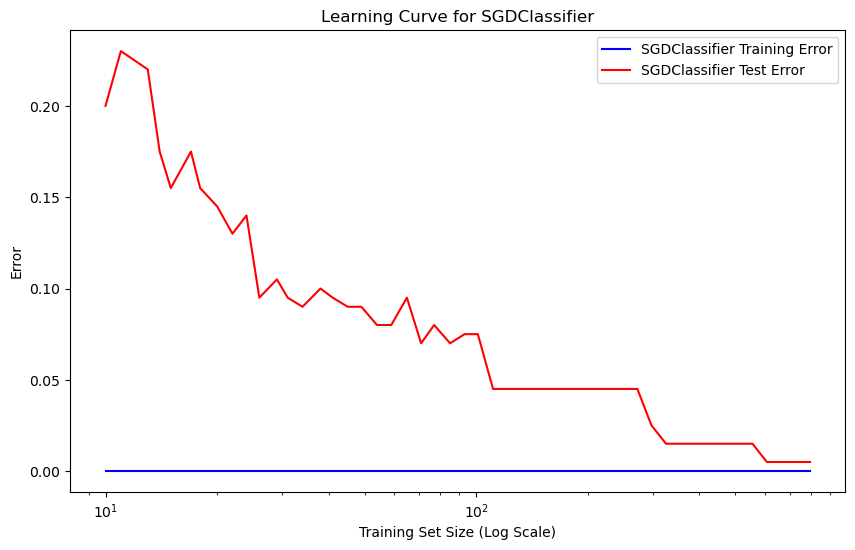

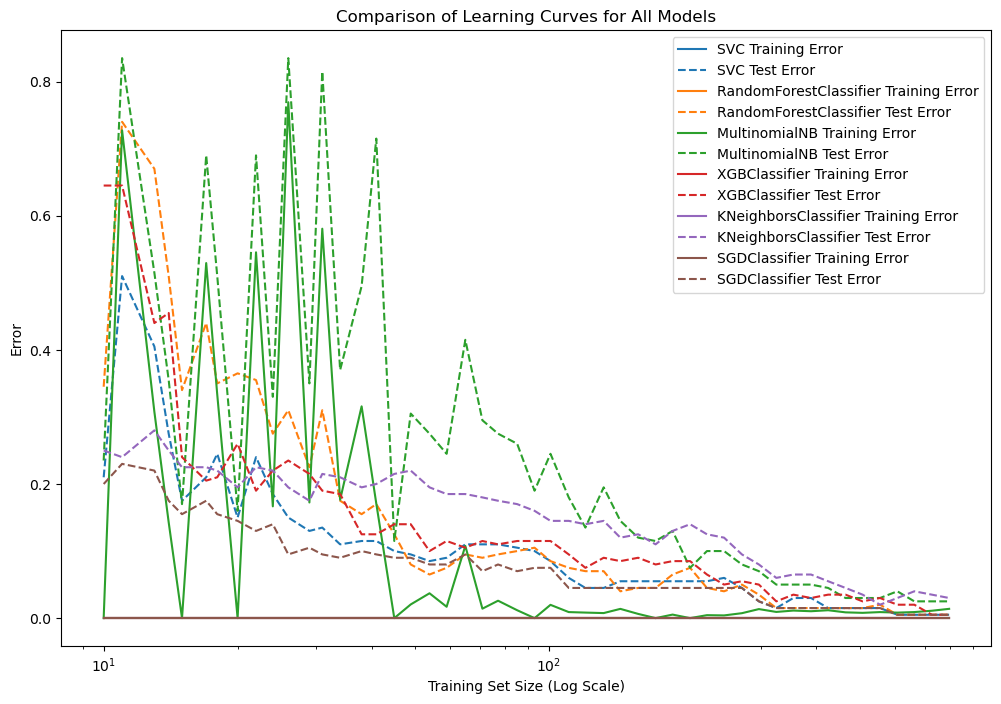

In [22]:
import numpy as np


# Create lists to store metrics for all models
metrics_all_models = {
    "model_name": [],
    "train_errors": [],
    "test_errors": [],
    "train_precision": [],
    "test_precision": [],
    "train_recall": [],
    "test_recall": [],
    "train_f1": [],
    "test_f1": []
}

# Logarithmic intervals for training set sizes
training_sizes = np.logspace(1, np.log10(X_train.shape[0]-5), num=50, dtype=int)  # Log scale for m

# Function for stratified sampling
def stratified_subset(X, y, m):
    """Returns a stratified subset of size m."""
    X_sub, _, y_sub, _ = train_test_split(X, y, train_size=m, stratify=y, random_state=42)
    return X_sub, y_sub

# Loop through each model and perform bias-variance analysis
for model_name, best_model in grid_search_best:
    print(f"Evaluating {model_name} for Bias-Variance Analysis...")

    # Initialize lists to store metrics
    train_errors, test_errors = [], []
    train_precision, test_precision = [], []
    train_recall, test_recall = [], []
    train_f1, test_f1 = [], []

    # Loop over different training set sizes
    for m in training_sizes:
        try:
            # Stratified subset of training data
            X_train_sub, y_train_sub = stratified_subset(X_train, y_train_encoded, m)
            
            # Fit the model
            best_model.fit(X_train_sub, y_train_sub)

            # Predictions for training and test sets
            y_train_pred = best_model.predict(X_train_sub)
            y_test_pred = best_model.predict(X_test)

            # Training error (1 - accuracy)
            train_errors.append(1 - accuracy_score(y_train_sub, y_train_pred))
            # Test error (1 - accuracy)
            test_errors.append(1 - accuracy_score(y_test_encoded, y_test_pred))

            # Additional metrics
            train_precision.append(precision_score(y_train_sub, y_train_pred, average="weighted"))
            test_precision.append(precision_score(y_test_encoded, y_test_pred, average="weighted"))
            train_recall.append(recall_score(y_train_sub, y_train_pred, average="weighted"))
            test_recall.append(recall_score(y_test_encoded, y_test_pred, average="weighted"))
            train_f1.append(f1_score(y_train_sub, y_train_pred, average="weighted"))
            test_f1.append(f1_score(y_test_encoded, y_test_pred, average="weighted"))

        except Exception as e:
            print(f"Error at training size {m}: {e}")
            continue

    # Store metrics for the current model
    metrics_all_models["model_name"].append(model_name)
    metrics_all_models["train_errors"].append(train_errors)
    metrics_all_models["test_errors"].append(test_errors)
    metrics_all_models["train_precision"].append(train_precision)
    metrics_all_models["test_precision"].append(test_precision)
    metrics_all_models["train_recall"].append(train_recall)
    metrics_all_models["test_recall"].append(test_recall)
    metrics_all_models["train_f1"].append(train_f1)
    metrics_all_models["test_f1"].append(test_f1)

    # Plot learning curve for this model
    plt.figure(figsize=(10, 6))
    plt.plot(training_sizes[:len(train_errors)], train_errors, label=f"{model_name} Training Error", color="blue")
    plt.plot(training_sizes[:len(test_errors)], test_errors, label=f"{model_name} Test Error", color="red")
    plt.xlabel("Training Set Size (Log Scale)")
    plt.ylabel("Error")
    plt.title(f"Learning Curve for {model_name}")
    plt.xscale("log")
    plt.legend()
    plt.show()

# Plot all models together for comparison (Training and Test Errors)
plt.figure(figsize=(12, 8))
for i, model_name in enumerate(metrics_all_models["model_name"]):
    train_err = metrics_all_models["train_errors"][i]
    test_err = metrics_all_models["test_errors"][i]
    plt.plot(training_sizes[:len(train_err)], train_err, label=f"{model_name} Training Error", color=f"C{i}")
    plt.plot(training_sizes[:len(test_err)], test_err, label=f"{model_name} Test Error", color=f"C{i}", linestyle="--")
plt.xlabel("Training Set Size (Log Scale)")
plt.ylabel("Error")
plt.title("Comparison of Learning Curves for All Models")
plt.xscale("log")
plt.legend()
plt.show()

# Optional: Export metrics for further analysis
import pandas as pd
metrics_df = pd.DataFrame(metrics_all_models)
metrics_df.to_csv("bias_variance_metrics.csv", index=False)


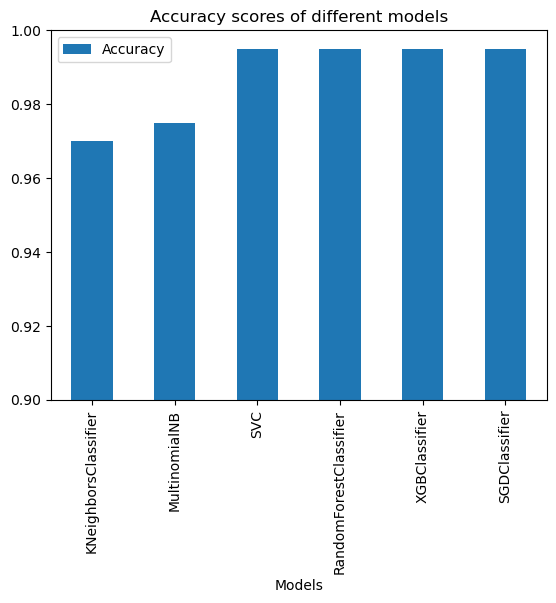

In [23]:
performance_df = pd.DataFrame(performance_data).sort_values(by='Accuracy')

performance_df.plot(kind='bar',x='Model', y='Accuracy')
plt.title("Accuracy scores of different models")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.show()

In [24]:
performance_df

,Model,Accuracy,Macro F1-Score
4,KNeighborsClassifier,0.970,0.968721
2,MultinomialNB,0.975,0.975394
0,SVC,0.995,0.994256
1,RandomForestClassifier,0.995,0.994256
3,XGBClassifier,0.995,0.994256
5,SGDClassifier,0.995,0.994256


# Using BERT

## Preprocessing the Data

In [25]:
from transformers import BertTokenizer
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler
from torch.cuda.amp import GradScaler, autocast

In [26]:
# Split the dataset into training and testing
X = df_scraped["Processed_Text"].tolist()
y = df_scraped["Label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2, stratify=y)

In [27]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=200, return_tensors="pt")
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=200, return_tensors="pt")

## Label Encoding

In [28]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## Prepare a Dataset for PyTorch

In [29]:
class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create datasets
train_dataset = MentalHealthDataset(train_encodings, y_train_encoded)
test_dataset = MentalHealthDataset(test_encodings, y_test_encoded)

## Load a pretrained BERT model

In [30]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set Up Training with PyTorch

In [31]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training Loop

In [38]:
# Scheduler for learning rate
num_training_steps = len(train_loader) * 5  # 5 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training loop
epochs = 5
model.train()

scaler = GradScaler()

# Training loop with mixed precision
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        batch = {key: val.to(device) for key, val in batch.items()}  # Move data to device

        with autocast():  # Enable mixed precision
            outputs = model(**batch)
            loss = outputs.loss  # Compute loss

        # Scale the loss for stability in mixed precision
        scaler.scale(loss).backward()

        # Step the optimizer using the scaled loss
        scaler.step(optimizer)
        scaler.update()  # Update the scale for next iteration

        # Step the learning rate scheduler
        lr_scheduler.step()

        # Reset the gradients
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1} completed!")

Epoch 1 completed!
Epoch 2 completed!
Epoch 3 completed!
Epoch 4 completed!
Epoch 5 completed!


In [39]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Decode labels
predictions = label_encoder.inverse_transform(predictions)
true_labels = label_encoder.inverse_transform(true_labels)

# Classification report
print(classification_report(true_labels, predictions))

                                precision    recall  f1-score   support

              anxiety disorder       0.98      1.00      0.99        40
              bipolar disorder       1.00      0.97      0.99        40
           clinical depression       0.97      0.97      0.97        40
post-traumatic stress disorder       1.00      1.00      1.00        40
                 schizophrenia       0.97      0.97      0.97        40

                      accuracy                           0.98       200
                     macro avg       0.99      0.98      0.98       200
                  weighted avg       0.99      0.98      0.98       200

